# Thresholding e segmentação por intensidade
## *Leonardo Sales Araujo*
### *PEMM/COPPE - Universidade Federal do Rio de Janeiro*

### A primeira parte consiste em carregar os módulos necessários

In [1]:
#carrega os módulos necessários ao código
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from skimage.restoration import denoise_nl_means,estimate_sigma,denoise_bilateral,denoise_wavelet,denoise_tv_chambolle
from skimage.morphology import disk

from skimage import color,img_as_float,img_as_ubyte,data,measure,filters,io,metrics,util

### Carrega-se a imagem original e a apresenta

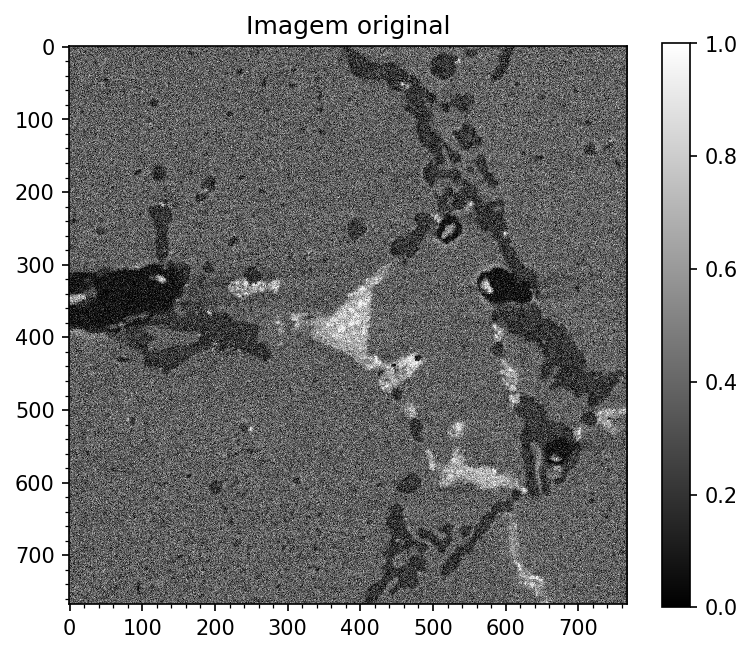

In [2]:
#carrega a imagem do subdiretorio "img" e a transforma em float (variando entre 0 e 1)
#essa etapa será necessária para estimar o desvio padrão do ruído
imagem = img_as_float(io.imread('img/im_ex_15.jpg'))

#mostra a figura original
plt.figure(1, figsize=(6,6),dpi=150)
plt.title('Imagem original')
plt.imshow(imagem, cmap='gray')
#plt.xlim(3600,3800)
#plt.ylim(1800,2000)
plt.minorticks_on()
#plt.grid(alpha=0.95,linestyle='-')
plt.colorbar(shrink=0.83)
plt.show()

### Primeiro deve-se estimar o desvio padrão do ruido, considerando-o Gaussiano.

https://pt.wikipedia.org/wiki/Ru%C3%ADdo_gaussiano

estimate_sigma:
https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.estimate_sigma

In [3]:
#estimando o desvio padrão do ruído gaussiano
sigma_est = np.mean(estimate_sigma(imagem,multichannel=False)) #se fosse ruído colorido, multichannel=True

#mostra o valor estimado de sigma
print(f'Estimativa do desvio padrão do ruído: {round(sigma_est,(5))}')

Estimativa do desvio padrão do ruído: 0.12064


### Metodologias de atenunação do ruído

denoise_nl_means: https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_nl_means

mediana: https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.median

total variation: https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_tv_chambolle

wavelet: https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_wavelet

Bilateral: https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_bilateral


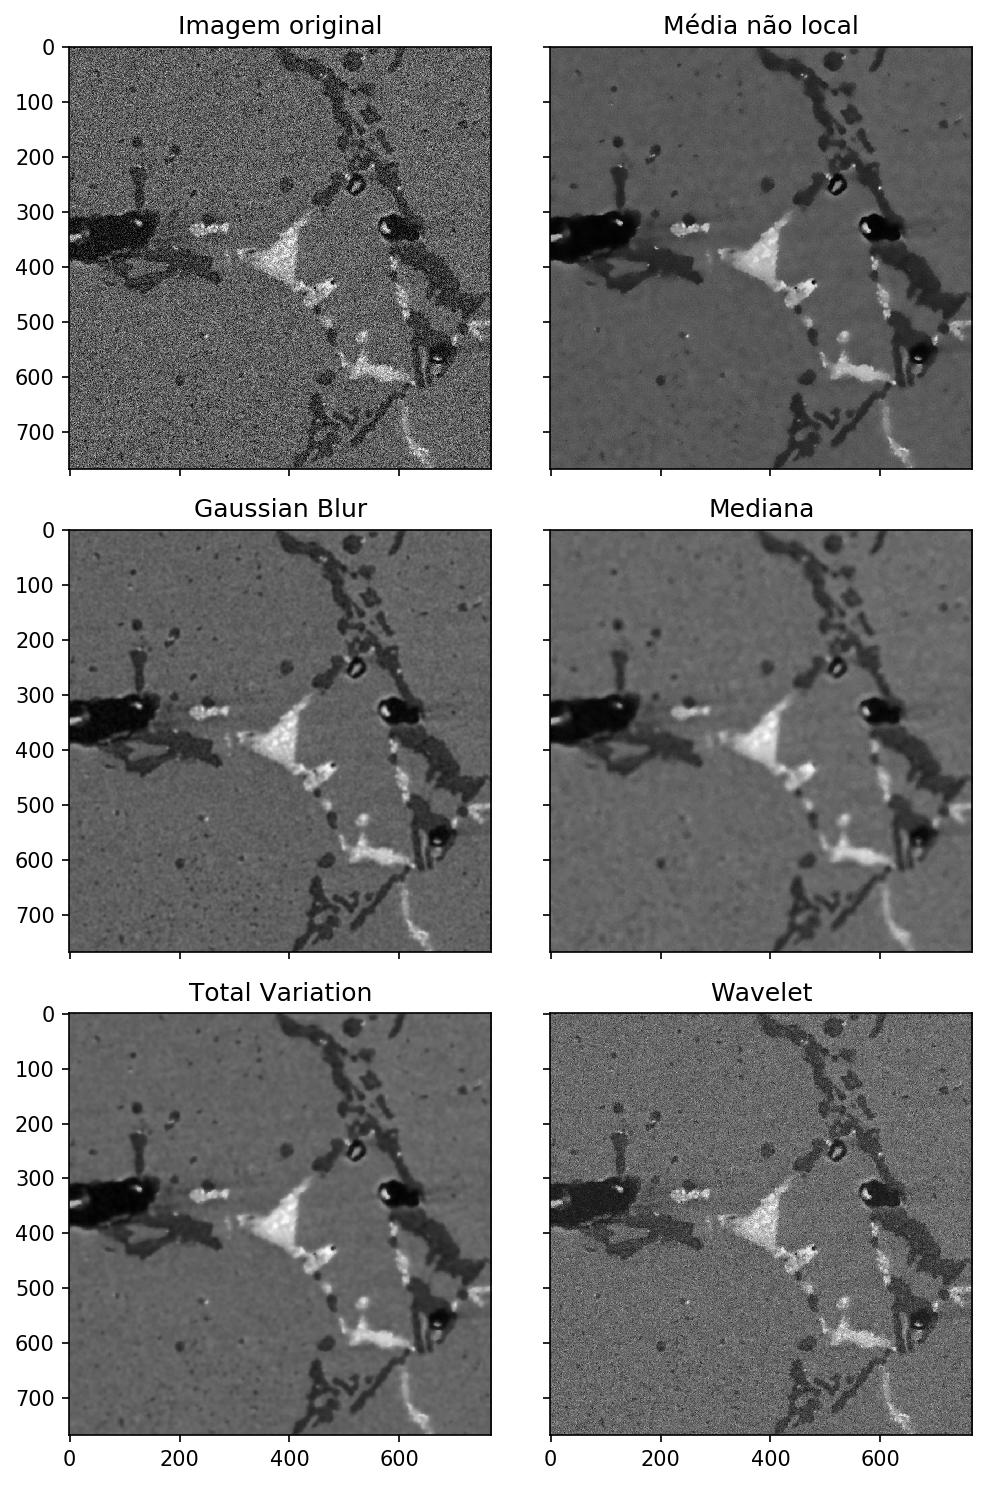

In [4]:
#média não local
patch_dnnm = dict(h=sigma_est, #distancia de Cut-off (níveis de cinza). Recomenda-se próximo ao valor de sigma
                patch_size=4, #região 5x5
                patch_distance=7, #área de busca 13 x 13
                fast_mode=True,
                multichannel=False)

corrigida_1 = denoise_nl_means(imagem,**patch_dnnm)

#gaussian blur
corrigida_2 = filters.gaussian(imagem,sigma=2)

#mediana
corrigida_3 = filters.median(imagem,disk(7)) #mediana com um disco de raio 7

#total variation
patch_tv = dict(weight = 0.3, #peso do filtro. Quanto maior, mais atenuação, ao custo da fidelidade
                n_iter_max = 200, #número máximo de iterações
                multichannel = False)

corrigida_4 = denoise_tv_chambolle(imagem,**patch_tv)

#wavelet
patch_wvl = dict(sigma=0.7*sigma_est,
                mode='soft', #define o tipo de denoising
                multichannel = False, rescale_sigma = True)
corrigida_5 = denoise_wavelet(imagem,**patch_wvl)


#mostra as imagens
fig,axs=plt.subplots(3,2,figsize=(7, 10),dpi=150,sharex=True, sharey=True)
#imagem 1
axs[0,0].imshow(imagem,cmap='gray')
axs[0,0].set_title("Imagem original")
#imagem 2
axs[0,1].imshow(corrigida_1, cmap='gray')
axs[0,1].set_title("Média não local")
#imagem 3
axs[1,0].imshow(corrigida_2, cmap='gray')
axs[1,0].set_title("Gaussian Blur")
#imagem 4
axs[1,1].imshow(corrigida_3, cmap='gray')
axs[1,1].set_title("Mediana")
#imagem 5
axs[2,0].imshow(corrigida_4, cmap='gray')
axs[2,0].set_title("Total Variation")
#imagem 6
axs[2,1].imshow(corrigida_5, cmap='gray')
axs[2,1].set_title("Wavelet")

fig.tight_layout()
    
plt.show()


### Para o caso do histograma, primeiro será necessário transformar o arquivo de float para 8 bits. Após a escolha do melhor processo de remoção do ruído, serão apresentados os histogramas das imagens original e corrigida.

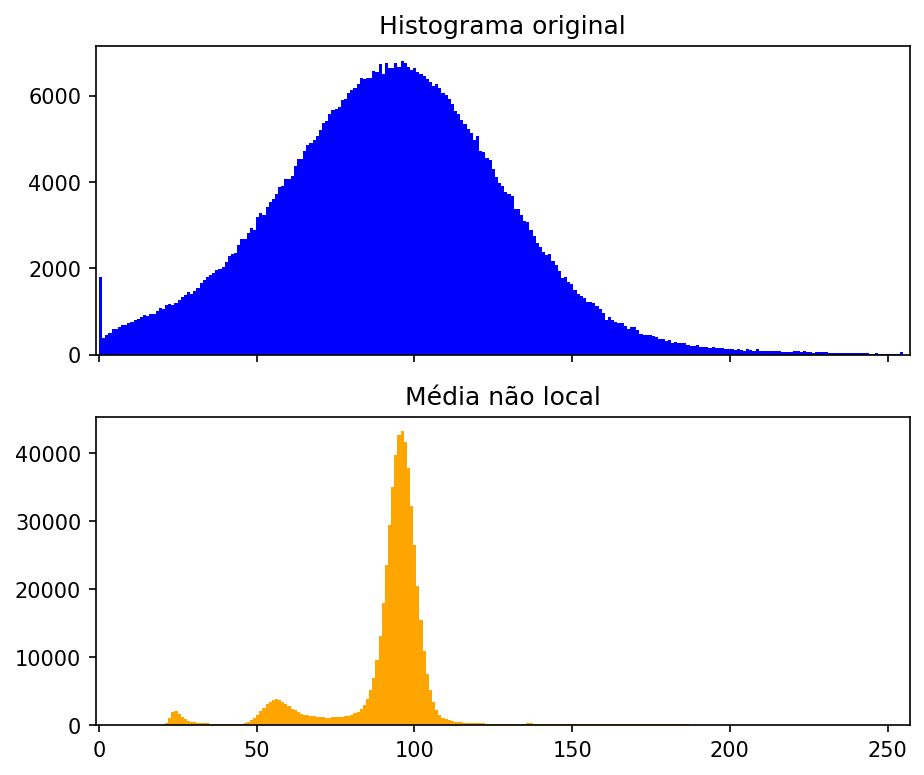

In [5]:
#convertendo de float para 8bits
imagem_8b = img_as_ubyte(imagem)
corrigida_1_8b = img_as_ubyte(corrigida_1)


#mostra os histogramas
fig,axs=plt.subplots(2,1,figsize=(7,6),dpi=150,sharex=True, sharey=False)
#imagem 1
axs[0].hist(imagem_8b.flat,bins=256,range=(0,255),color = 'blue')
axs[0].set_title("Histograma original")
#imagem 2
axs[1].hist(corrigida_1_8b.flat,bins=256,range=(0,255),color = 'orange')
axs[1].set_title("Média não local")

plt.xlim(-1, 257)
plt.show()

### No caso anterior, a contagem de pontos da matriz é muito superior às das outras morfologias. Portanto, é mais apropriado observar o log dos histogramas.

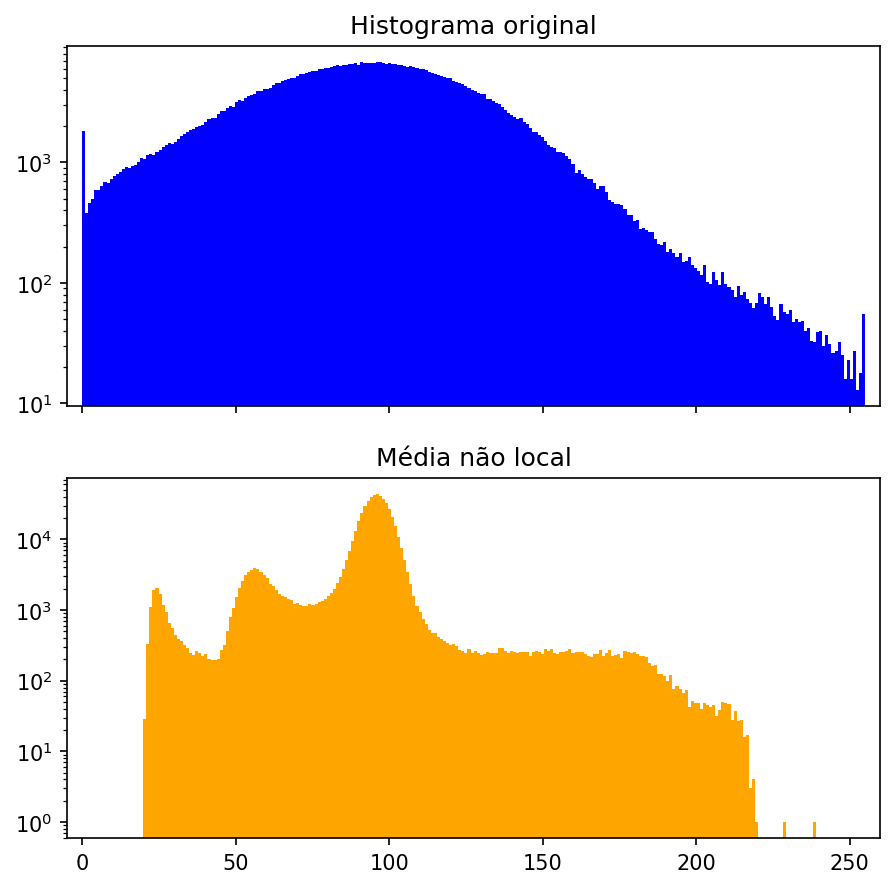

In [6]:
#mostra os histogramas com escala y em log
fig,axs=plt.subplots(2,1,figsize=(7,7),dpi=150,sharex=True, sharey=False)
#imagem 1
axs[0].hist(imagem_8b.flat,bins=256,range=(0,255),color = 'blue')
axs[0].set_title("Histograma original")
axs[0].set_yscale('log')
#imagem 2
axs[1].hist(corrigida_1_8b.flat,bins=256,range=(0,255),color = 'orange')
axs[1].set_title("Média não local")
axs[1].set_yscale('log')

plt.xlim(-5, 260)
plt.show()

### Nota-se que, o caso da imagem corrigida, há regiões que não foram "ocupadas". Nesse sentido, as intensidades podem ser expandidas. Para isso vamos:

1. Determinar qual o menor valor e deslocar o histograma dessa quantidade, de forma que o mínimo se torne o novo zero.

2. Transformar proporcionalmente o histograma, de forma a que o valor máximo corresponda a 1 (ou 255 em 8 bits)

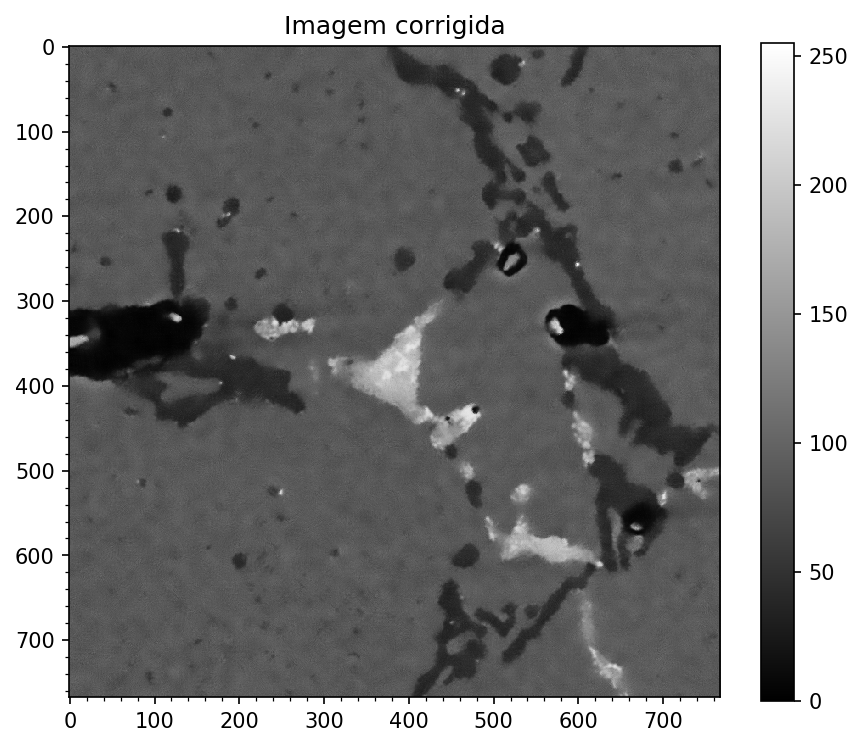

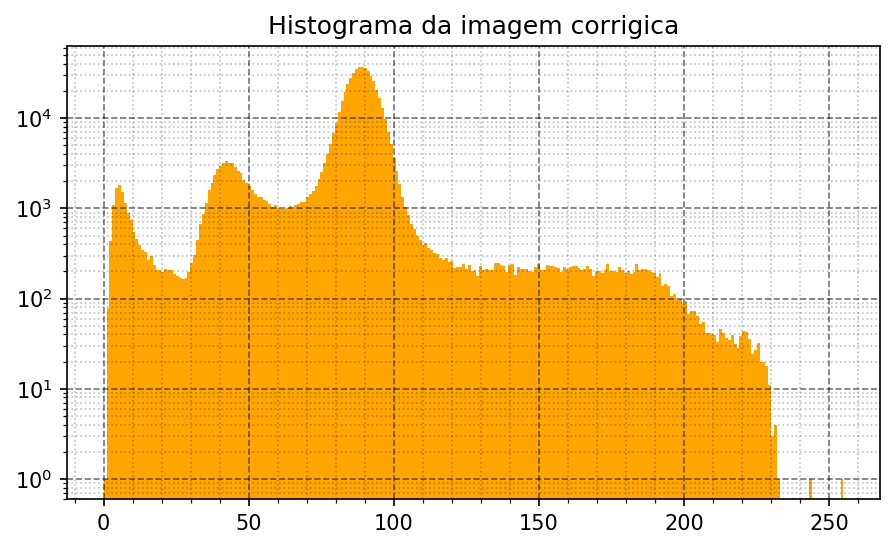

In [7]:
#desloca os valores e corrige a curva
corrigida_1_aj1 = cv2.absdiff(corrigida_1,min(corrigida_1.flat))
corrigida_1_aj2 = cv2.divide(corrigida_1_aj1,max(corrigida_1_aj1.flat))

#transforma em 8-bits
corrigida_1_aj2_8b = img_as_ubyte(corrigida_1_aj2)

plt.figure(3, figsize=(7,7),dpi=150)
plt.title('Imagem corrigida')
plt.imshow(corrigida_1_aj2_8b, cmap='gray')
plt.minorticks_on()
plt.colorbar(shrink=0.83)

plt.figure(4, figsize=(7,4),dpi=150)
plt.hist(corrigida_1_aj2_8b.flat,bins=256,color = 'orange')
plt.title("Histograma da imagem corrigica")
plt.minorticks_on()
plt.grid(alpha=0.55,which='major',linestyle='--',color = 'black')
plt.grid(alpha=0.25,which='minor',linestyle=':',color = 'black')
plt.yscale('log')

### Plota as diferentes regiões para definir os valores de corte para segmentação

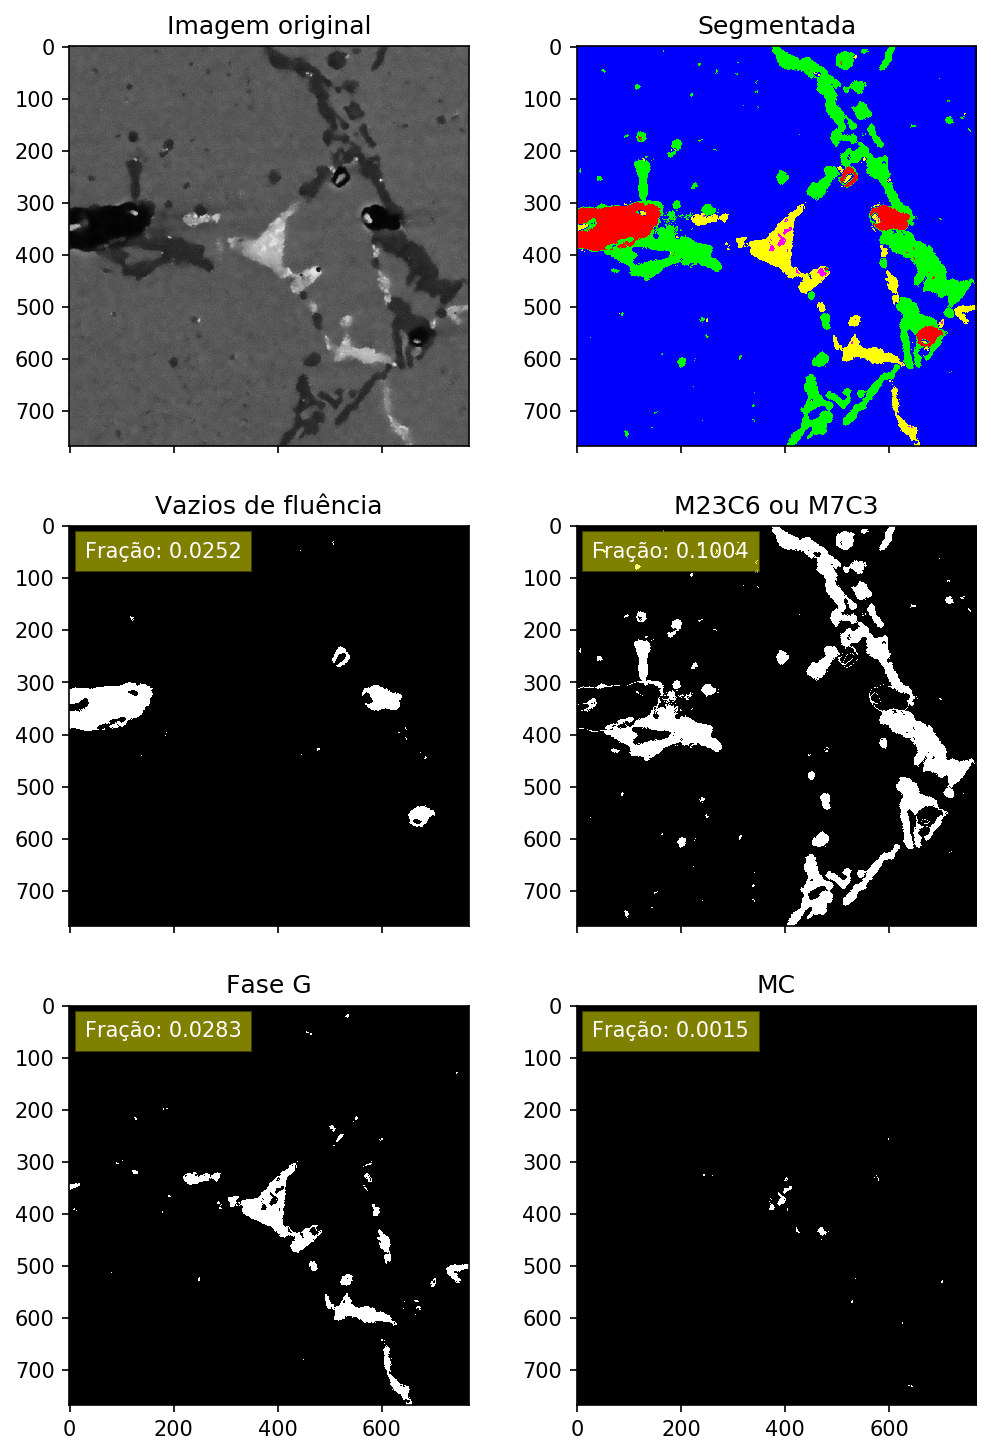

In [8]:
#definine os segmentos e os pontos de corte baseados na análise do histograma
seg1 = (corrigida_1_aj2_8b <= 30)
seg2 = (corrigida_1_aj2_8b >30) & (corrigida_1_aj2_8b <=65)
seg3 = (corrigida_1_aj2_8b >65) & (corrigida_1_aj2_8b <=120)
seg4 = (corrigida_1_aj2_8b >120) & (corrigida_1_aj2_8b <=205)
seg5 = (corrigida_1_aj2_8b >205)

#determina a quantidade de pontos para cada região e sua proporção
num_px_im = len(corrigida_1_aj2_8b[0])*len(corrigida_1_aj2_8b[1])
      
fr_1 = np.sum(seg1)/num_px_im
fr_2 = np.sum(seg2)/num_px_im
fr_3 = np.sum(seg3)/num_px_im
fr_4 = np.sum(seg4)/num_px_im
fr_5 = np.sum(seg5)/num_px_im

#cria uma imagem do mesmo tamanho da imagem corrigida e com valores zero
mascara = np.zeros((corrigida_1_aj2_8b.shape[0],corrigida_1_aj2_8b.shape[1],3))

#define as cores das mascaras
mascara[seg1]=(1,0,0)
mascara[seg2]=(0,1,0)
mascara[seg3]=(0,0,1)
mascara[seg4]=(1,1,0)
mascara[seg5]=(1,0,1)

#mostra os histogramas com escala y em log
fig,axs=plt.subplots(3,2,figsize=(8,12),dpi=150,sharex=True, sharey=False)
#imagem 1
axs[0,0].imshow(corrigida_1_aj2_8b, cmap='gray')
axs[0,0].set_title("Imagem original")
#imagem 2
axs[0,1].imshow(mascara)
axs[0,1].set_title("Segmentada")
#imagem 3
axs[1,0].imshow(seg1,cmap='gray')
axs[1,0].set_title("Vazios de fluência")
axs[1,0].text(30, 60, f'Fração: {round(fr_1,4)}',color='white', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
#imagem 4
axs[1,1].imshow(seg2,cmap='gray')
axs[1,1].set_title("M23C6 ou M7C3")
axs[1,1].text(30, 60, f'Fração: {round(fr_2,4)}',color='white', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
#imagem 5
axs[2,0].imshow(seg4,cmap='gray')
axs[2,0].set_title("Fase G")
axs[2,0].text(30, 60, f'Fração: {round(fr_4,4)}',color='white', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
#imagem 6
axs[2,1].imshow(seg5,cmap='gray')
axs[2,1].set_title("MC")
axs[2,1].text(30, 60, f'Fração: {round(fr_5,4)}',color='white', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})

plt.show()